# Learning Galaxy Properties with Mangrove 

#### By: [Christian Kragh Jespersen](https://astrockragh.github.io/) [<img src ="https://cdn-icons-png.flaticon.com/512/25/25231.png" alt="drawing" width="20" style="background-color: transparent"/>](https://github.com/astrockragh) [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/astrockragh?lang=en ""), Princeton University (e-mail: ckragh@princeton.edu)

### Hi everyone and welcome to this short tutorial on how to use our model, **Mangrove**!

### For more info you can check out our [paper](arxiv.org/abs/2210.13473)



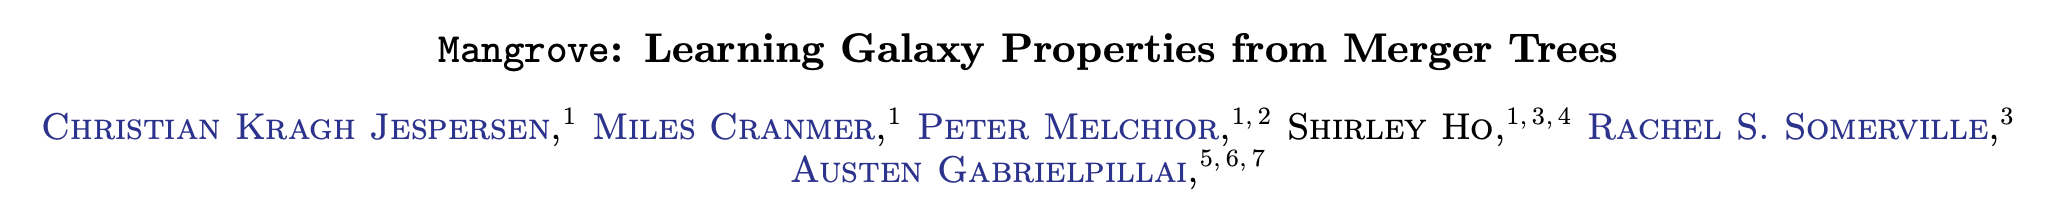

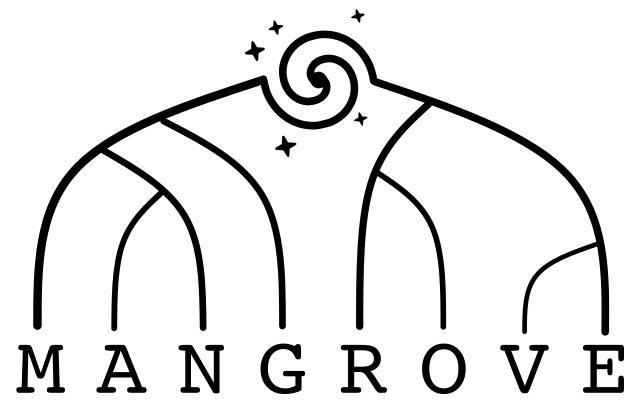

#### Mangrove is a Graph Neural Network, a type of Neural Network that take graphs as inputs. 

#### Mangrove was born when we noticed that galaxies can easily be encoded as living on causal graphs! 

#### This is because galaxies form in halos, which form hierachically over. This means that halos merge over time, becoming larger and more massive with time. We can encode this kind of evolution in a **merger tree**! 

#### When we visualize it, it's quite obvious that it's a graph.



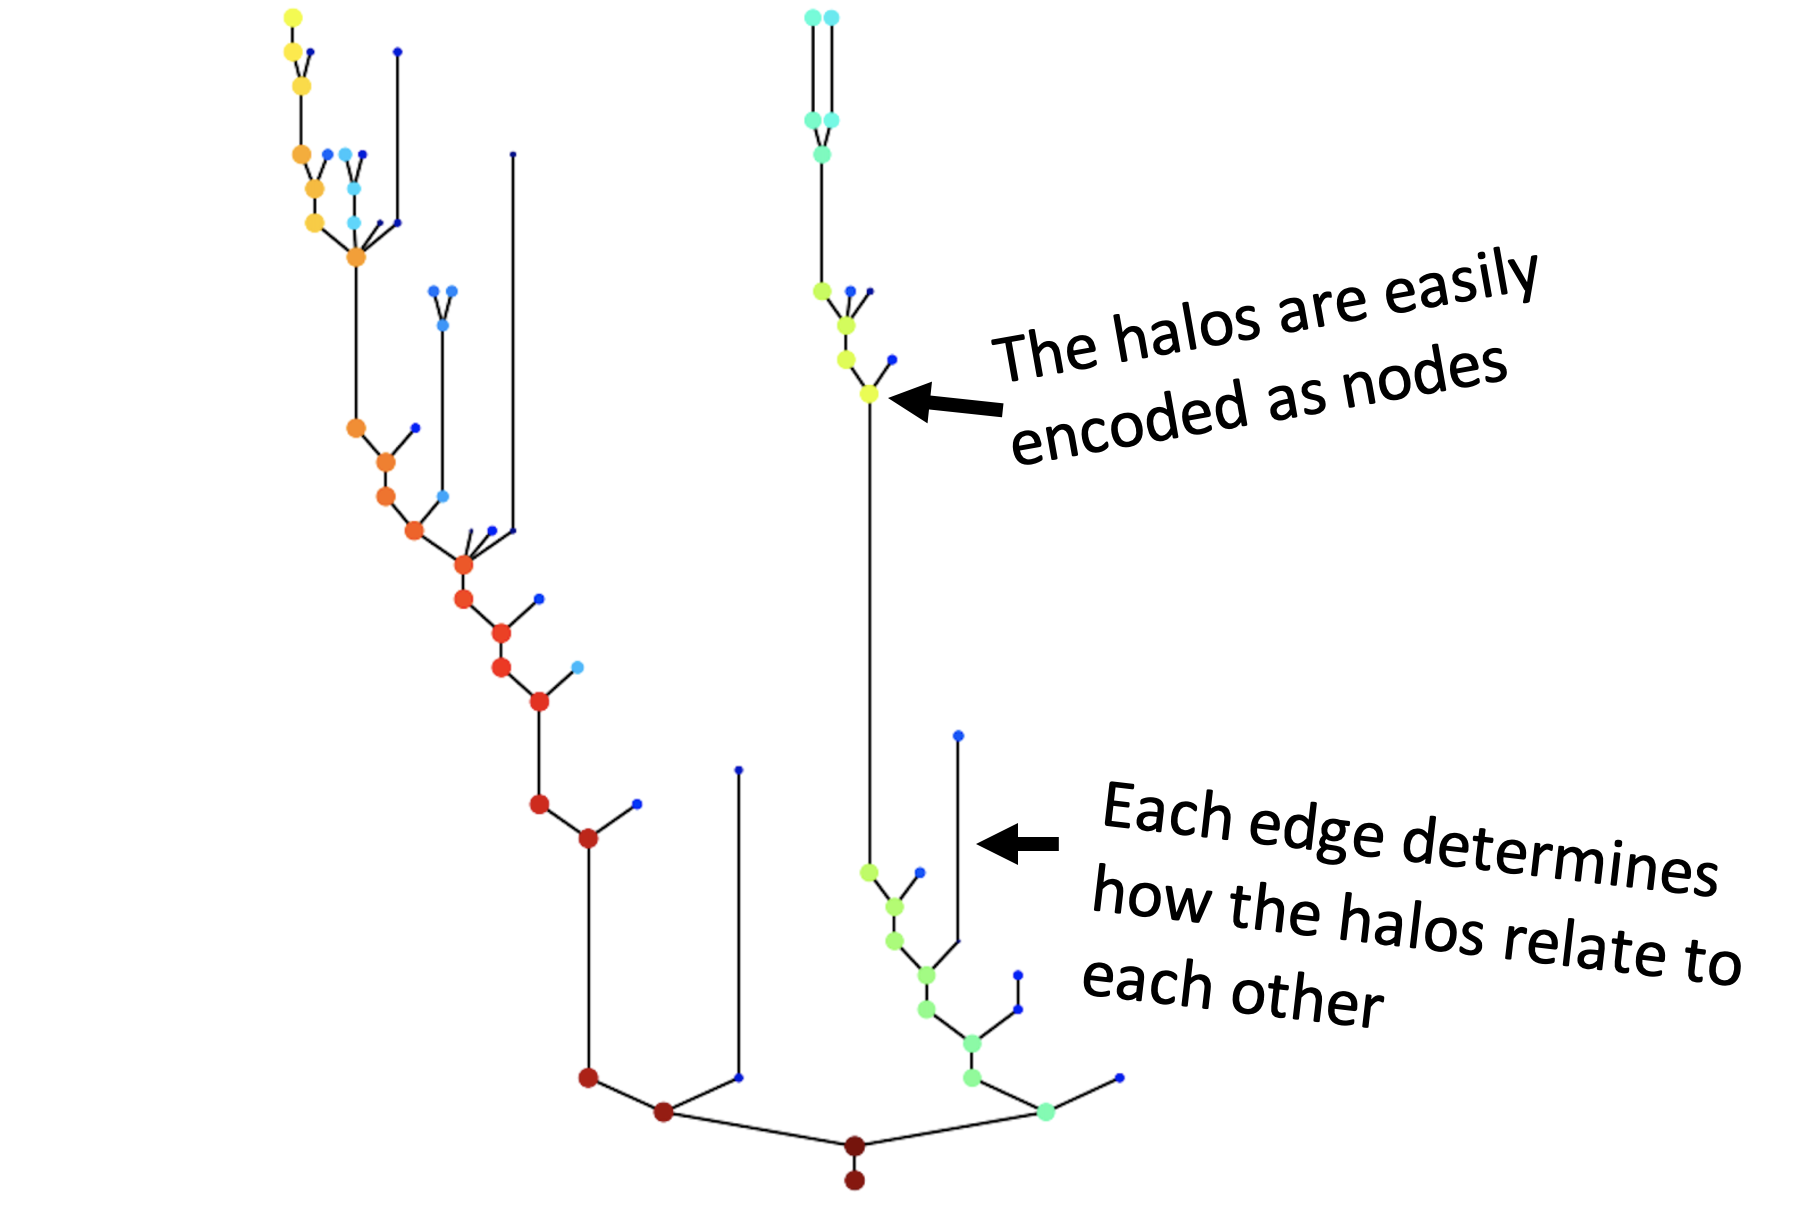

#### Traditionally, we have focused on mapping directly from each halo to each galaxy, but this neglects a lot of information about how the galaxy formed, information that **is in the merger tree**. Because this approach neglects **a lot** of information, we unsurprisingly get imprecise mappings between the galaxies and dark matter.

#### This means that when we build Machine Learning (ML) models to learn about galaxies, we **have** to take the **history** of the galaxy into account, which Mangrove does via the Merger Tree!

#### When we do these mappings, we are basing them on simulations, so there is very little reason to base our mappings only on the information - lacking halos, when we get the halos from the same sims that we can get merger trees from.

## Let's get started with some code

#### First we'll need to install a few things and make sure that Google is letting us use a GPU. The GPU should be on by default, but you can check it by going to the upper left hand menu, selecting Runtime -> Change runtime type and check that GPU is selected under Hardware Accelerator.

#### All installations should be done by running the next three cells, so let's go ahead and do that

In [1]:
# we're going to be using Pytorch, the most widely used framework for ML research right now.
# Pytorch is already installed so all we have to worry about is that everything else we do is compatible with our version of Pytorch
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.13.1+cu116


In [2]:
#here we load the libraries needed for doing ML on graphs, pytorch geometric, and a little package that can help with making our training faster
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 11.1 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=0ede4aacd305a46564cebb4f1b3d528fa79e0cc6607f020cadac0a4166e2a3db
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 4.8 MB/s eta 0:00:00


### Alright, now everything we need is installed, so let's import it all

In [3]:
#@title import everything
import pickle, time, os
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import random
import string
from tqdm.notebook import tqdm
from accelerate import Accelerator
from datetime import date

import torch_geometric as tg
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from IPython import display
import matplotlib as mpl

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

# Now let's define our model, Mangrove

#### As said, Mangrove is a Graph Neural Network (GNN), which tries to predict galaxy properties based on the merger tree. GNNs like Mangrove work by learning three functions.

* A node function, which acts on the features of each node by itself.
* A message passing function, which learn how to optimally add information to each node based on the features of its neighbors (the nodes that it is connected to).
* A decoder function, which takes some aggregator function over all the nodes, like a sum over all node features, and then decodes that to the desired out.

#### All in all, the path from simulation to prediction is ...

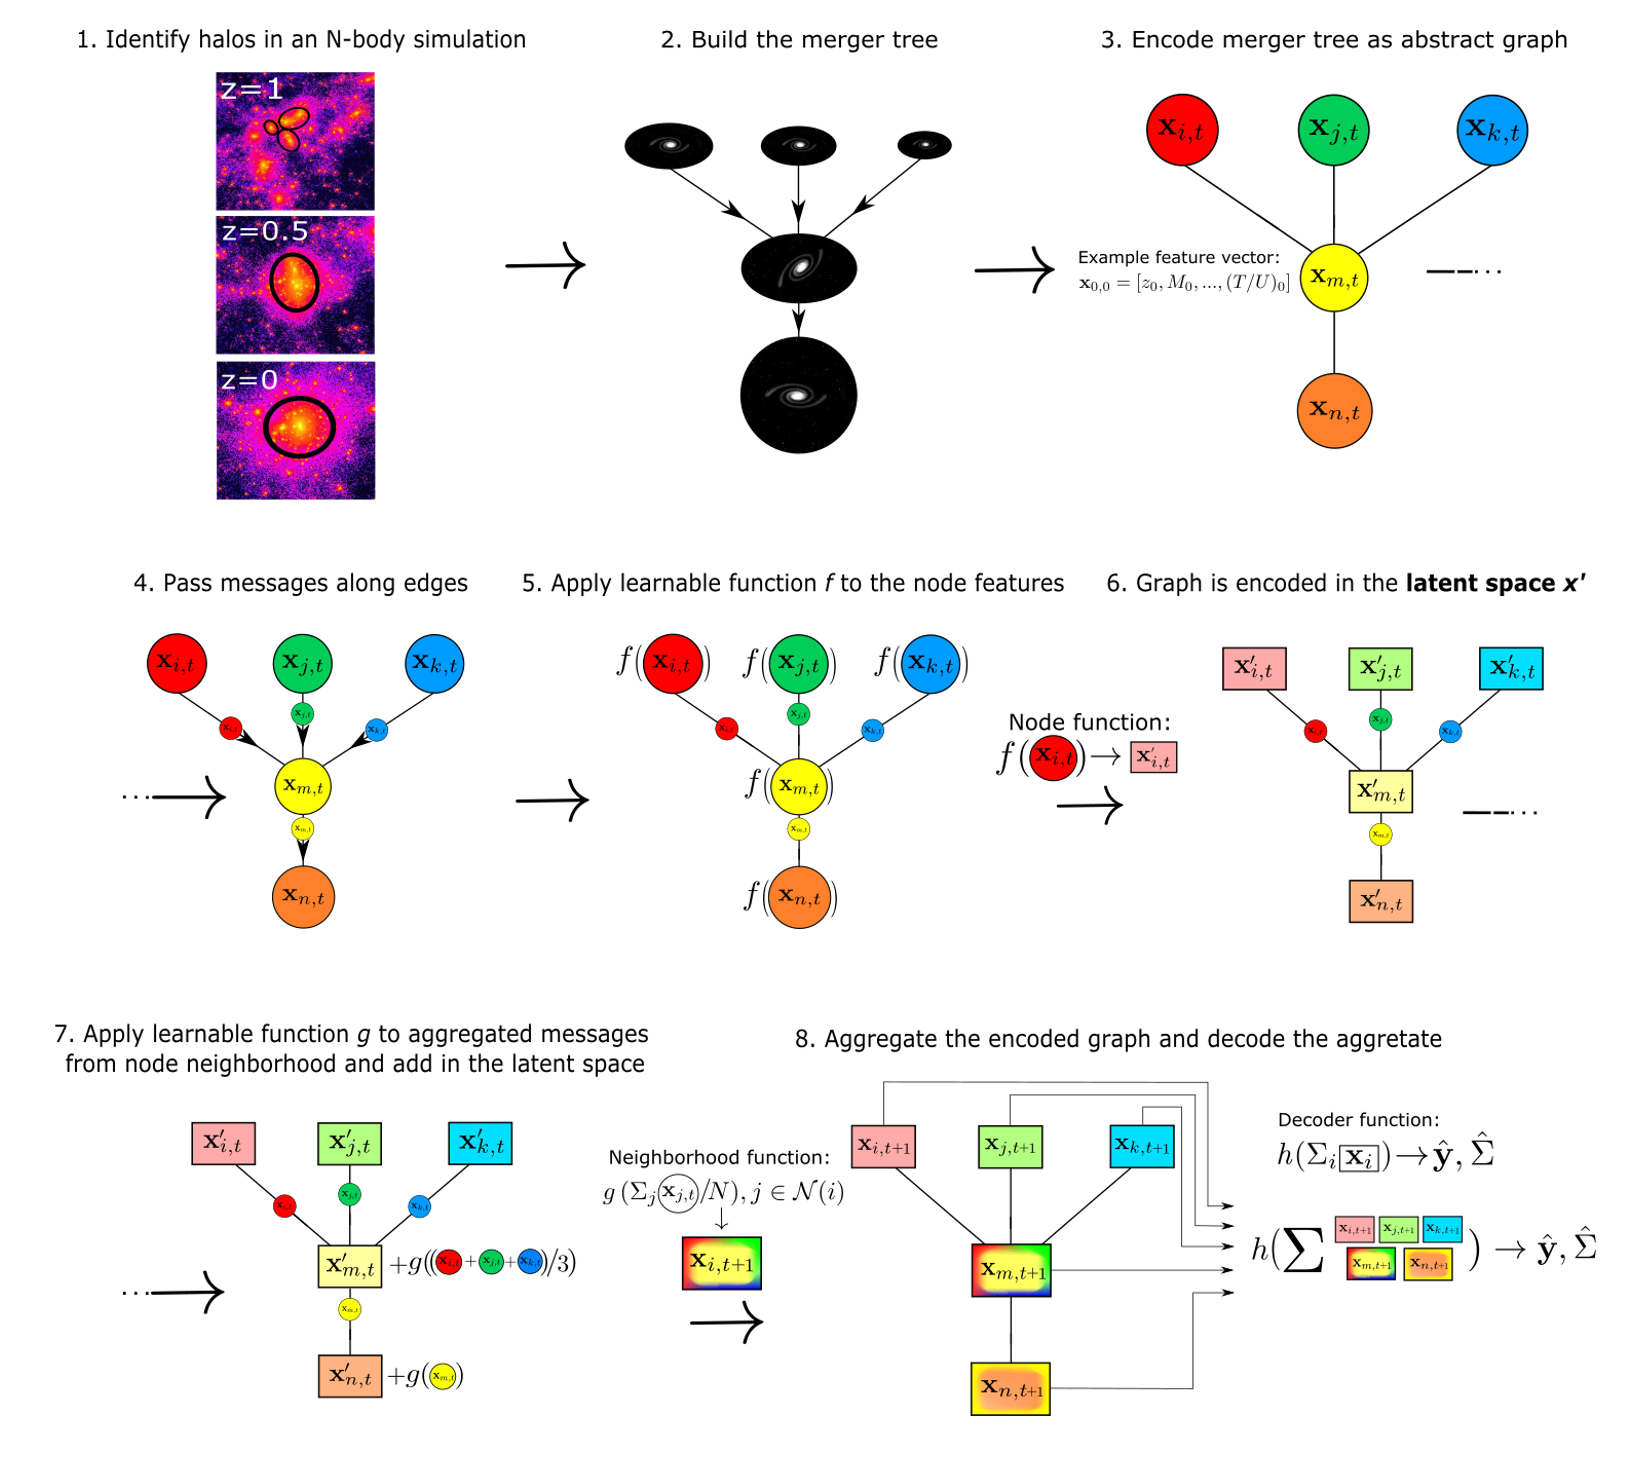

#### Now let's define the model in code - unless you are trying to do some kind of research based on my code (in which case, go to https://github.com/astrockragh/Mangrove), don't worry too much about this. 

#### The only difference compared to above is that there is more than one message - passing step, and there are separate decoder functions for each property that we want to predict

In [4]:
#@title This just defines all the functions that we need, just run it once
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, LeakyReLU, Module, ReLU, Sequential, ModuleList
from torch_geometric.nn import SAGEConv, norm, global_add_pool, global_max_pool
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch import cat, square,zeros, clone, abs, sigmoid, float32, tanh, clamp, log, sum, square

class MLP(Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        '''Simple MLP class with ReLU activiation + layernorm'''

        layers = [Linear(n_in, hidden), ReLU()]
        for i in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU()) 
        if layer_norm:
            layers.append(LayerNorm(hidden))
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class Mangrove(Module):
    def __init__(self, hidden_channels, in_channels, out_channels, encode=True, conv_layers=5, conv_activation='relu', 
                    decode_layers=3, decode_activation='leakyrelu', layernorm=True, variance=1, agg='sum', rho=0):
        super(Mangrove, self).__init__()
        '''Model built upon the GraphSAGE convolutional layer. This is a node only model (no global, no edge).
        Model takes a data object from a dataloader in the forward call and takes out the rest itself. 
        hidden_channels, n_in, n_out must be specified
        Most other things can be customized at wish, e.g. activation functions for which ReLU and LeakyReLU can be used
        Pay attention especially to the variance/rho key words, they dictate whether or not the model will predict '''
        self.encode=encode
        if self.encode:
            self.node_enc = MLP(in_channels, hidden_channels, layer_norm=True) #whether or not to encode the node features before any message passing
        self.decode_activation=decode_activation
        self.conv_activation=conv_activation
        self.layernorm=layernorm
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.hidden_channels=hidden_channels
        self.variance=variance
        self.agg=agg
        self.rho=rho
        ########################
        # Convolutional Layers #
        ######################## 

        self.convs=ModuleList()
        if self.encode:
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        else:
            self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(int(conv_layers-1)):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        ##################
        # Decode Layers #
        ##################       

        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(out_channels):
            self.decoder=ModuleList()
            self.norm=ModuleList()
            for i in range(decode_layers):
                if i==decode_layers-1: ## if final layer, make layer with only one output
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))  
                    self.decoder.append(Linear(hidden_channels, 1))
                else:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, hidden_channels))
            self.decoders.append(self.decoder)
            self.norms.append(self.norm)

        ###################
        # Variance Layers #
        ###################

        if variance:
            self.sigs = ModuleList()
            self.sig_norms = ModuleList()
            for _ in range(out_channels):
                self.sig=ModuleList()
                self.sig_norm=ModuleList()
                for i in range(decode_layers):
                    if i==decode_layers-1:
                        self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.sig.append(Linear(hidden_channels, 1))
                    else:
                        self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.sig.append(Linear(hidden_channels, hidden_channels))
                self.sigs.append(self.sig)
                self.sig_norms.append(self.sig_norm)

        ######################
        # Co-Variance Layers #
        ######################

        if self.rho!=0:
            self.rhos = ModuleList()
            self.rho_norms = ModuleList()
            for _ in range(self.rho):
                self.rho_l=ModuleList()
                self.rho_norm=ModuleList()
                for i in range(decode_layers):
                    if i==decode_layers-1:
                        self.rho_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.rho_l.append(Linear(hidden_channels, 1))
                    else:
                        self.rho_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.rho_l.append(Linear(hidden_channels, hidden_channels))
                self.rhos.append(self.rho_l)
                self.rho_norms.append(self.rho_norm)
        
        #####################
        # Activation Layers #
        #####################
        
        self.conv_act=self.conv_act_f()
        self.decode_act=self.decode_act_f() ## could apply later

    def conv_act_f(self):
        if self.conv_activation =='relu':
            print('RelU conv activation')
            act = ReLU()
            return act
        if self.conv_activation =='leakyrelu':
            print('LeakyRelU conv activation')
            act=LeakyReLU()
            return act
        if not self.conv_activation:
            raise ValueError("Please specify a conv activation function")

    def decode_act_f(self):
        if self.decode_activation =='relu':
            print('RelU decode activation')
            act = ReLU()
            return act
        if self.decode_activation =='leakyrelu':
            print('LeakyRelU decode activation')
            act=LeakyReLU()
            return act
        if not self.decode_activation:
            print("Please specify a decode activation function")
            return None

    def forward(self, graph):

        #get the data
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        #encode
        if self.encode:
            x = self.node_enc(x)
        
        #convolutions 
        for conv in self.convs:
            x = conv(x, edge_index)
            x=self.conv_act(x) ##choose whichever
        if self.agg=='sum':  ## sum for physics
            x = global_add_pool(x, batch)
        if self.agg=='max':
            x = global_max_pool(x, batch)
        
        #decoder
        
        x_out=[]
        for norm, decode in zip(self.norms, self.decoders):
            x1=clone(x)
            for n, d in zip(norm, decode):
                x1=d(n(x1))
                x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
            x_out.append(x1)
        x_out=cat(x_out, dim=1)
        
        # variance
        if self.variance:
            sig=[]
            for norm, decode in zip(self.sig_norms, self.sigs):
                x1=clone(x)
                for n, d in zip(norm, decode):
                    x1=d(n(x1))
                    x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                sig.append(x1)
            sig=abs(cat(sig, dim=1)) #stability

        if self.rho!=0:
            rho=[]
            for norm, decode in zip(self.rho_norms, self.rhos):
                x1=clone(x)
                for n, d in zip(norm, decode):
                    x1=d(n(x1))
                    x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                rho.append(x1)
            rho=cat(rho, dim=1)
        
        if self.variance:
            if self.rho!=0:
                return x_out, sig, clamp(tanh(rho), min=-0.999, max=0.999) #stability
            else:
                return x_out, sig
        else:
            return x_out

def GaussND(pred, ys, var):
    '''General uncorrelated gaussian, if you're having trouble you can try adding a small number to your sigmas for stability'''
    z=(pred-ys)/var
    sigloss=sum(log(var))
    err_loss = sum((square(z)))/2
    
    return err_loss+sigloss, err_loss, sigloss   

def simple_plot1(ys, preds, ax, epoch = 1000, r = [5,12.5], bins = 50, xt = 0.1, yt = 0.8, dy = 0.05):
  std = np.std(ys - preds, axis = 0)
  mu = np.mean(ys - preds, axis = 0)
  rho = np.corrcoef(ys,preds)[0][1]
  ax.plot(r,r, 'k--', label='Perfect correspondence')
  vals, x, y, hist = ax.hist2d(np.hstack(ys)+9, np.hstack(preds)+9, bins = bins, range = [r, r], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
  ax.text(xt,yt, r'$\sigma$ : '+f'{std:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-dy, f'Bias : {mu:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontsize=12, transform=ax.transAxes)
  ax.set(title=f"Epoch {epoch}", xlabel = r'SAM "True" $M_{*}$', ylabel = r'Mangrove predicted $M_{*}$')
  ax.legend(fontsize=12)

def simple_plot(ys, preds):
  std = np.std(ys - preds, axis = 0)
  mu = np.mean(ys - preds, axis = 0)
  rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0][1]
  ax.plot(r,r, 'k--', label='Perfect correspondence')
  vals, x, y, hist = ax.hist2d(np.hstack(ys)+9, np.hstack(preds)+9, bins = bins, range = [r, r], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
  ax.text(xt,yt, r'$\sigma$ : '+f'{std[0]:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-dy, f'Bias : {mu[0]:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontsize=12, transform=ax.transAxes)
  ax.set(title=f"Epoch {epoch}", xlabel = r'SAM "True" $M_{*}$', ylabel = r'Mangrove predicted $M_{*}$')
  ax.legend(fontsize=12)


def train(epoch, loader):
  model.train()
  return_loss = 0
  er_loss = 0
  si_loss = 0
  for data in loader:
    if lossfunc == 'gauss':
      out, var = model(data)  
      loss, err_loss, sig_loss = GaussND(out, data.y.view(-1,n_targ), var)
      si_loss+=sig_loss
    if lossfunc == 'L2':
      out = model(data)  
      loss = MSELoss()(out, data.y.view(-1,n_targ))
      er_loss+=loss
    if l1_lambda!=0:
      l1_norm = sum(p.abs().sum() for p in model.parameters())
    else:
      l1_norm = 0
    if l2_lambda!=0:
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    else:
      l2_norm = 0
    loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
    return_loss+=loss
    accelerator.backward(loss)
    optimizer.step() 
    optimizer.zero_grad()
    lr_scheduler.step(epoch)

  return return_loss, er_loss, si_loss, l1_lambda * l1_norm, l2_lambda * l2_norm

#### Now let's download some data. Here we use a subset (25%, 1.56 GB) of the data used. All data features have had a Gaussian transformation applied, so all of their distributions are as close as possible to Gaussian. This just aids in the stability of the training. The full train/test set that was used is available in [this folder](https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4) - if you use it please give [our paper](https://arxiv.org/abs/2210.13473) a citation!

#### We'll also download some config files, a prior results file and a pretrained version of Mangrove!

#### Everything is downloaded to a non - permanent folder and is within the RAM limits of this notebook, so don't worry 😉

#### If this does not work (Google puts a limit on the total number of gdown calls in a 24 hr period), uncomment download via DropBox in the cell below.

#### Alternatively, just go the links below and add the files to your personal drive manually and import them from there, then everything should be okay! 

In [5]:
!gdown 'https://drive.google.com/u/0/uc?id=192_gOXbEAhp4BSARobCsmJP2f98LsbGG' # 25% of full data file, 1.56 GB
!gdown 'https://drive.google.com/u/0/uc?id=1FjyePBL8FNfTudRDMffHmamnBVq7EKAW' # configuration file
!gdown 'https://drive.google.com/u/0/uc?id=17U1qqOvLj2J8TK0LTFUeMJcR26xLq5bQ' # model
!gdown 'https://drive.google.com/u/0/uc?id=12MCG8u6TYNSD-Y5exWe1yvu7rYUHQCyR' # results file

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/u/0/uc?id=192_gOXbEAhp4BSARobCsmJP2f98LsbGG 

Downloading...
From: https://drive.google.com/u/0/uc?id=1FjyePBL8FNfTudRDMffHmamnBVq7EKAW
To: /content/construct_dict.pkl
100% 852/852 [00:00<00:00, 1.28MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=17U1qqOvLj2J8TK0LTFUeMJcR26xLq5bQ
To: /content/model_best.pt
100% 2.42M/2.42M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=12MCG8u6TYNSD-Y5exWe1yvu7rYUHQCyR
To: /content/result_dict.pkl
100% 2.82M/2.82M [00:00<00:00, 171MB/s]


In [6]:
#ATTENTION!  Uncomment and run only if google drive is denying access, dropbox is slower but more reliable!
!wget 'https://www.dropbox.com/s/mq7m8xocsohpq3w/data25.pkl' -P /content #25% of full data file, 1.56 GB

--2023-02-03 03:47:31--  https://www.dropbox.com/s/mq7m8xocsohpq3w/data25.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/mq7m8xocsohpq3w/data25.pkl [following]
--2023-02-03 03:47:32--  https://www.dropbox.com/s/raw/mq7m8xocsohpq3w/data25.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38c649fa765583d0f1cdeb4a0b.dl.dropboxusercontent.com/cd/0/inline/B1yT4gqsI1m-RDXTLu-ba5ArmAdDXkvx_uEJseObEnoIjfUWeLLYOFxAbrSQt4nuzSgEutKakeo-YVu5Le-66lqe51XtHA0MvdMbCHvset-RM5X74ekxZG99GVi62feEeaTiYu48Ox_ebD3WMGuXdslNrHQ5VPD0ZVYrC7Nyfl-hZw/file# [following]
--2023-02-03 03:47:32--  https://uc38c649fa765583d0f1cdeb4a0b.dl.dropboxusercontent.com/cd/0/inline/B1yT4gqsI1m-RDXTLu-ba5ArmAdDXkvx_uEJseObEnoIjfUWeLLYOFxAbrSQt4nuzSgEutKakeo-YVu5Le-66l

In [16]:
data = pickle.load(open('/content/data25.pkl', 'rb'))
config = pickle.load(open('/content/construct_dict.pkl', 'rb'))

In [17]:
data = data[::2]

####  So now that we have our data loaded, let's test the pretrained model! 

####  First we select just the targets that the model was trained for, i.e. stellar mass, cold gas mass, gas metallicity, instanteneous and time-averaged star formation rate and black hole mass ($M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$). 


In [18]:
#@title Then we set up the model, and get it on the GPU
targets = config['data_params']['targets'] ## these are the targets used in the paper
# there is a list of others in the MangroveData folder here https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4

test_data = []
for i, d in enumerate(data):
  test_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))

test_loader=DataLoader(test_data, batch_size=256, shuffle=0, num_workers=2)   

n_feat = len(test_data[0].x[0])
n_targ = len(test_data[0].y)
config['hyper_params']['in_channels']=n_feat
config['hyper_params']['out_channels']=n_targ

model = Mangrove(**config['hyper_params'])
model.load_state_dict(torch.load('/content/model_best.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

model, optimizer, test_loader = accelerator.prepare(model, optimizer, test_loader)
def test(loader, model, lossfunc):
    '''returns targets and predictions'''
    ys, pred, Mh=[], [], []
    model.eval()
    outs = []
    ys = []
    vars= []
    with torch.no_grad():
        for data in loader: 
            if lossfunc == 'gauss':
              out, var = model(data)
              vars.append(var)
            if lossfunc == 'L2':
              out = model(data)
            ys.append(data.y.view(-1,n_targ))
            pred.append(out)
            

    ys = torch.vstack(ys)
    pred = torch.vstack(pred)
    if lossfunc == 'gauss':
      vars = torch.vstack(vars)
      vars = vars.cpu().numpy()
    return ys.cpu().numpy(), pred.cpu().numpy(), vars, Mh

RelU conv activation
LeakyRelU decode activation


#### Alright now everything is set up and the pre-trained version of Mangrove is loaded, let's run a test, get some metrics and plot the results.

#### We measure the scatter and bias of the residuals in dex. The best predictions will have zero scatter and zero bias.

#### Here, I'll just plot the stellar mass, but feel free to change the index k to anything else. The simple_plot command is set up to do stellar mass, so the numerical values may be off otherwise

#### The plot shows the truth i.e. what we're trying to hit on the x-axis, versus Mangroves prediction on the y-axis. This way, ideal predictions lie along the diagonal of the plot.

In [19]:
#testing, here we get targets, predictions, uncertainties and halo mass out
#the halo masses might look a little weird to those familiar with them - that's just because they've been transformed to resemble a Gaussian
ys, preds, sigs, Mhalo = test(test_loader, model, lossfunc='gauss')

##notice that we're predicting across 25% of the TNG100 volume in a couple of seconds

Scatters for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$  [0.06251626 0.15034333 0.10753825 0.34023798 0.32347098 0.12133408]
Biases for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$  [ 0.0014032   0.00123658 -0.00483361  0.01262928  0.01193789  0.00754471]


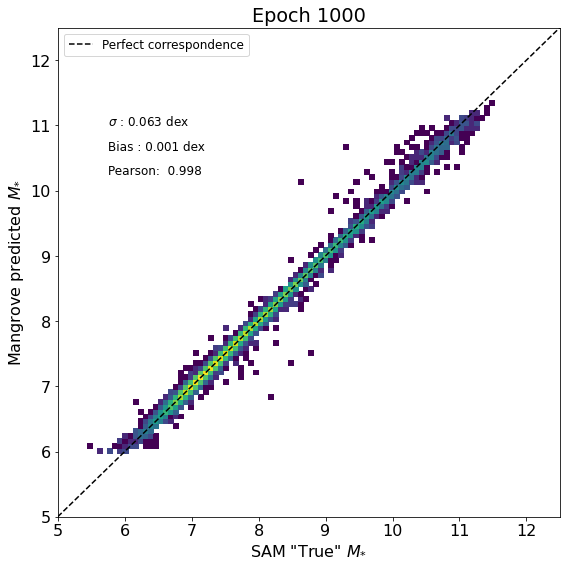

In [20]:
#calculate std/bias (remember that part of the training set used for training this model is in here, so the performance might be a little better than it should be!)

#here we do a correction to get the actual metallicity, not the total metal mass
ys[:,2]-=ys[:,1] 
preds[:,2]-=preds[:,1]
print(r'Scatters for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$ ', np.std(ys-preds, axis=0))
print(r'Biases for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$ ', np.mean(ys-preds, axis=0))

k = 0 #plot stellar mass
fig, ax = plt.subplots(figsize = (9,9))
simple_plot1(ys[:,k], preds[:,k], ax = ax, bins=100)

## Looks pretty good!!

#### But of course, you should be able to train the model from scratch yourself as well, so let's set that up. Here we set up two datasets. One with the merger trees and one using just the final halo within which the galaxy lives. Both datasets have only the stellar mass of the galaxy as a target.

#### The version of Mangrove trained in the paper uses a Gaussian loss function, but let's train the model using a simple Mean Squared Error (MSE/L2) - loss, since it converges a bit faster. The model will simply try to minimize $(M_{*,true}-M_{*,predicted})^2$ across the dataset.

#### Feel free to try to add some regularization (restricting the amplitude of the weights and biases of the model), turning up the number of epochs, or trying out the Gaussian loss function.

#### The model should converge after ~200 epochs with the MSE loss function, but the results will be good after 100 as well, and we don't want to waste any time so let's just go with 100

In [21]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import MSELoss

l1_lambda = 0 #L1 regularization strength
l2_lambda = 0 #L2 regularization strength
# lossfunc = 'gauss' # The Gaussian Loss takes longer to converge, but converges to a better minimum + you get uncertainties! So turn n_epochs up to ~ 200 in order to get decent results
lossfunc = 'L2'
n_epochs = 100 # number of epoch

test_idx = np.random.choice(np.arange(len(data)), size = int(len(data)*0.2))

targets = [8] ## M_star, see https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4 for other targets!

test_data, train_data = [], []
for i, d in enumerate(data):
  if i in test_idx:
    test_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))
  else:
    train_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))

n_feat = len(train_data[0].x[0])
n_targ = len(train_data[0].y)

test_loader=DataLoader(test_data, batch_size=256, shuffle=0, num_workers=2)   
train_loader=DataLoader(train_data, batch_size=256, shuffle=1, num_workers=2)

test_data_final, train_data_final = [], []
for i, d in enumerate(data):
  if i in test_idx:
    test_data_final.append(Data(x=torch.tensor([d.x[0].cpu().numpy()], dtype=torch.float), edge_index=torch.tensor([[0],[0]], dtype=torch.long), y=d.y[targets]))
  else:
    train_data_final.append(Data(x=torch.tensor([d.x[0].cpu().numpy()], dtype=torch.float), edge_index=torch.tensor([[0],[0]], dtype=torch.long), y=d.y[targets]))

test_loader_final=DataLoader(test_data_final, batch_size=256, shuffle=0, num_workers=2)   
train_loader_final=DataLoader(train_data_final, batch_size=256, shuffle=1, num_workers=2)

config['hyper_params']['in_channels']=n_feat
config['hyper_params']['out_channels']=n_targ

#### Here we set up the model that will try to regress on the final halo only

### This uses **no graph information**!

There is an option for plotting the results as you go along, by simply setting plot = True. I'd recommend leaving it off for the first time you run this cell!

colab can be a bit slow, so keep an eye on the time estime

In [22]:
plot = False
val_epoch = 5

if lossfunc == 'gauss':
  config['hyper_params']['variance'] = True
if lossfunc == 'L2':
  config['hyper_params']['variance'] = False
model = Mangrove(**config['hyper_params'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

_, _, test_loader_final = accelerator.prepare(model, optimizer, test_loader_final)
model, optimizer, train_loader_final = accelerator.prepare(model, optimizer, train_loader_final)

lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=n_epochs*len(train_loader), pct_start=0.15, final_div_factor=1e3)

if plot:
  fig, ax = plt.subplots(figsize = (8,8))
  bins = 100
  r = [5,12.5]
  xt = 0.1
  yt =0.8
  dy = 0.05
precisionHalo = []
for epoch in tqdm(range(n_epochs)):
  trainloss, err_loss, sig_loss, l1_loss, l2_loss = train(epoch, train_loader_final)

  if (epoch+1)%val_epoch == 0:
    print(f'{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision, {sig_loss:.2E} coming from the magnitude of the uncertainties \n and {l1_loss+l2_loss:.2E} coming from regularization')
    ys, preds, sigs, Mhalo = test(test_loader_final, model, lossfunc = lossfunc)
    rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0,1]
    std = np.std(ys-preds, axis=0)
    precisionHalo.append(std)
    mu = np.mean(ys-preds, axis=0)
    print(f'Epoch {epoch+1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}')
    if plot:
      ax.cla()
      simple_plot(ys, preds)
      display.clear_output(wait=True)
      display.display(fig)

RelU conv activation
LeakyRelU decode activation


  0%|          | 0/100 [00:00<?, ?it/s]

7.87E+01 total loss, 7.87E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
Epoch 5: sigma: 0.6759, bias: -1.1376, Pearson correlation 0.7645
6.45E+01 total loss, 6.45E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
Epoch 10: sigma: 0.6526, bias: -0.9998, Pearson correlation 0.7817
5.00E+01 total loss, 5.00E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
Epoch 15: sigma: 0.6817, bias: -0.8047, Pearson correlation 0.8161
3.67E+01 total loss, 3.67E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
Epoch 20: sigma: 0.5539, bias: -0.7056, Pearson correlation 0.8466
2.56E+01 total loss, 2.56E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 

## Let's plot the results

Best epoch had a scatter of 0.1650 dex


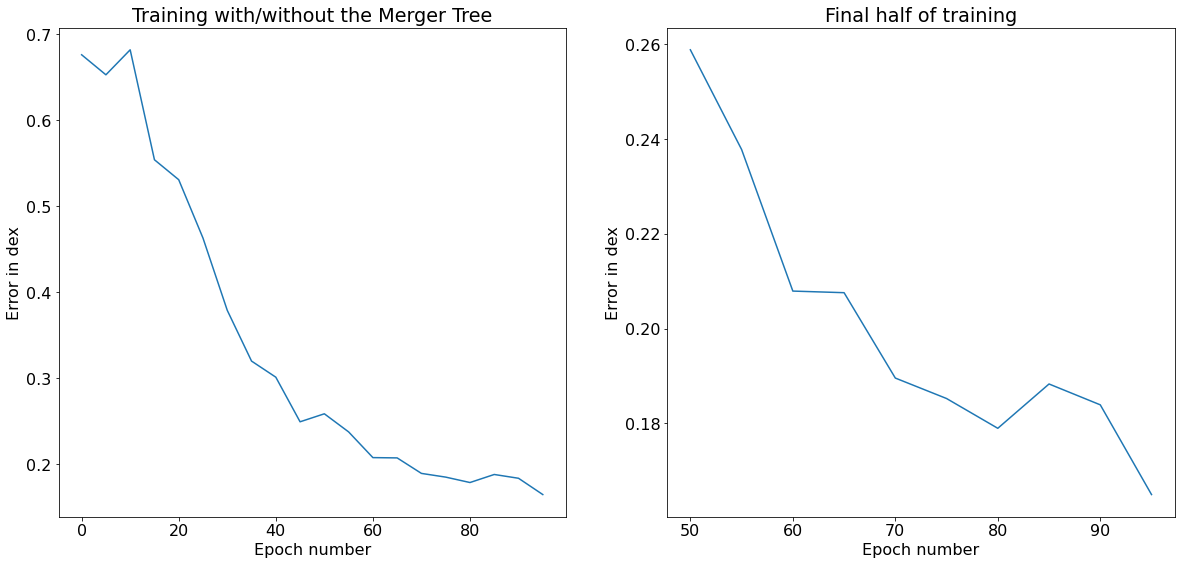

In [23]:
figs, axs = plt.subplots(1,2, figsize = (20,9))
axs[0].plot(np.arange(0,n_epochs, val_epoch), precisionHalo, label = 'Mangrove using only halo')
axs[0].set(xlabel='Epoch number', ylabel='Error in dex', title = 'Training with/without the Merger Tree')

axs[1].plot(np.arange(n_epochs//2,n_epochs, val_epoch), precisionHalo[n_epochs//(2*val_epoch):], label = 'Mangrove using only halo')
axs[1].set(xlabel='Epoch number', ylabel='Error in dex', title = 'Final half of training')

print(f'Best epoch had a scatter of {np.min(precisionHalo):.4f} dex')

### The model is getting better, and given enough time and data, it will plateau around a scatter of 0.13 dex. 

### This is good, but we can do better!

# **Let's do the merger trees!**

#### Since there is more information it takes a bit longer to train, but let's train it for the same number of epochs and see what we get

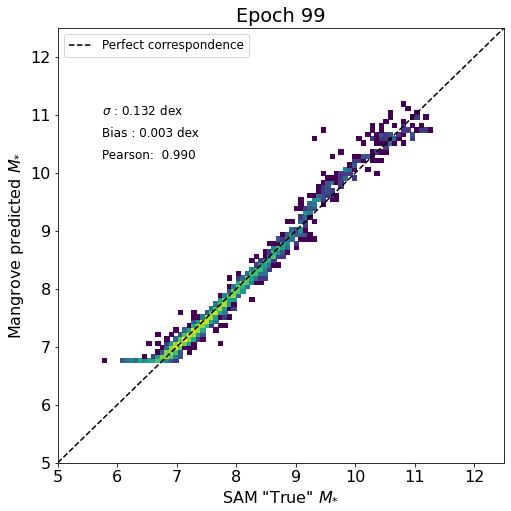

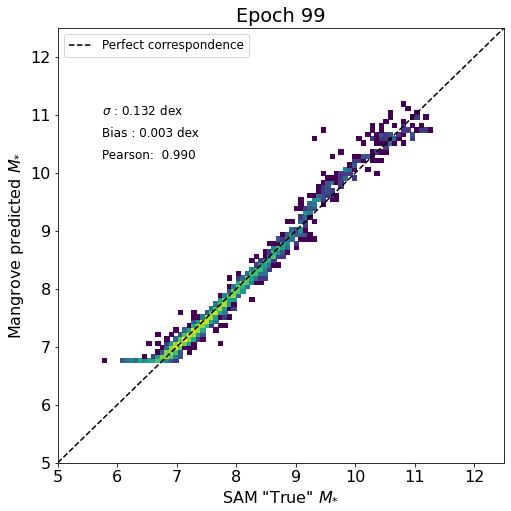

In [24]:
plot = True

if lossfunc == 'gauss':
  config['hyper_params']['variance'] = True
if lossfunc == 'L2':
  config['hyper_params']['variance'] = False
model = Mangrove(**config['hyper_params'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=n_epochs*len(train_loader), pct_start=0.15, final_div_factor=1e3)

if plot:
  fig, ax = plt.subplots(figsize = (8,8))
  bins = 100
  r = [5,12.5]
  xt = 0.1
  yt =0.8
  dy = 0.05

precisionTree = []
for epoch in tqdm(range(n_epochs)):
  trainloss, err_loss, sig_loss, l1_loss, l2_loss = train(epoch, train_loader)
  if (epoch+1)%val_epoch == 0:
    print(f'{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision, {sig_loss:.2E} coming from the magnitude of the uncertainties \n and {l1_loss+l2_loss:2E} coming from regularization')
    ys, preds, sigs, Mhalo = test(test_loader, model, lossfunc = lossfunc)
    rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0,1]
    std = np.std(ys-preds, axis=0)
    mu = np.mean(ys-preds, axis=0)
    precisionTree.append(std)
    print(f'Epoch {epoch+1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}')

    if plot:
      ax.cla()
      simple_plot(ys, preds)
      display.clear_output(wait=True)
      display.display(fig)

## Now we can plot the results from both training runs

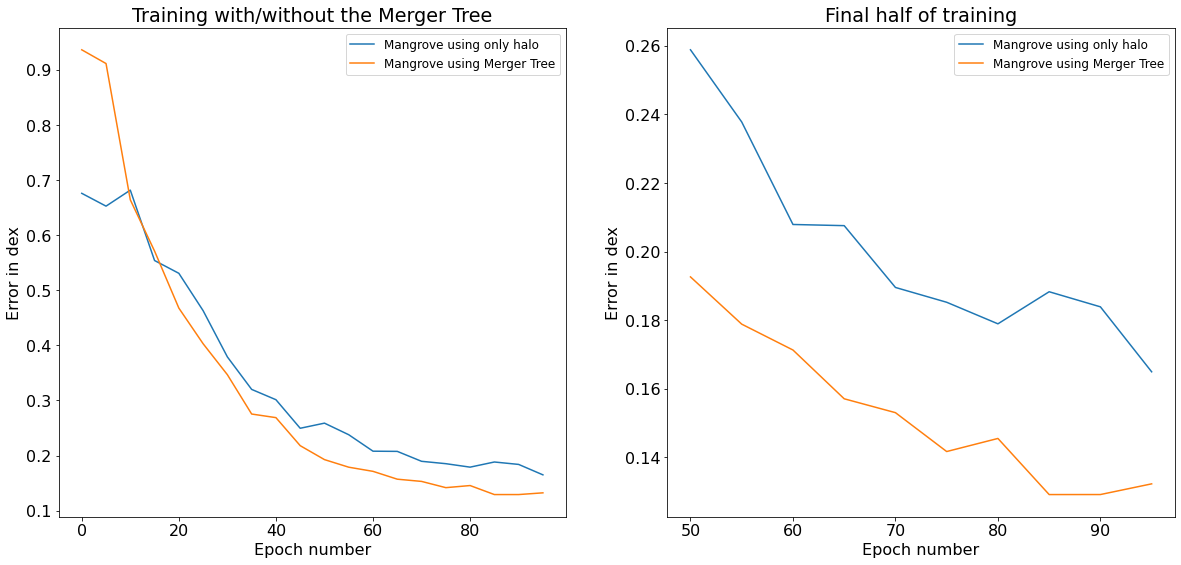

In [25]:
axs[0].plot(np.arange(0,n_epochs, val_epoch), precisionTree, label = 'Mangrove using Merger Tree')

axs[1].plot(np.arange(n_epochs//2,n_epochs, val_epoch), precisionTree[n_epochs//(2*val_epoch):], label = 'Mangrove using Merger Tree')

axs[0].legend(fontsize = 12)
axs[1].legend(fontsize = 12)
figs

#### If training has converged (otherwise increase the number of epochs), it will be obvious that predicting based on the merger trees is **a lot better**! 🥳

#What does this mean?

#### It means that the **history** of each galaxy matters, or in more human terms: Galaxies *remember*!

#### This means that future galaxy models **need** to find a way to deal with differences in formation scenarios. This is hard to do with observations, so a lot more work is needed there.

#### On the other hand, this work really opens up galaxy formation to deep learning! Processes that take place *on graphs* are hard to deal with without GNNs, since they are intrisically very high dimensional.

## Mangrove is just a first step - future work will undoubtedly perform even better!


> Feel free to use anything in this notebook or on my GitHub https://github.com/astrockragh/Mangrove, but please cite our paper, https://arxiv.org/abs/2210.13473, if you do!


Thanks for reading along and congratulations for making it to the end! 🎉🎉

I'll leave you with a nice figure from the paper, which shows predicting like the simple_plot function, but here we filtered our predictions to only contain the 50% of predictions that Mangrove was most confident that it had gotten right. The results are quite spectacular!


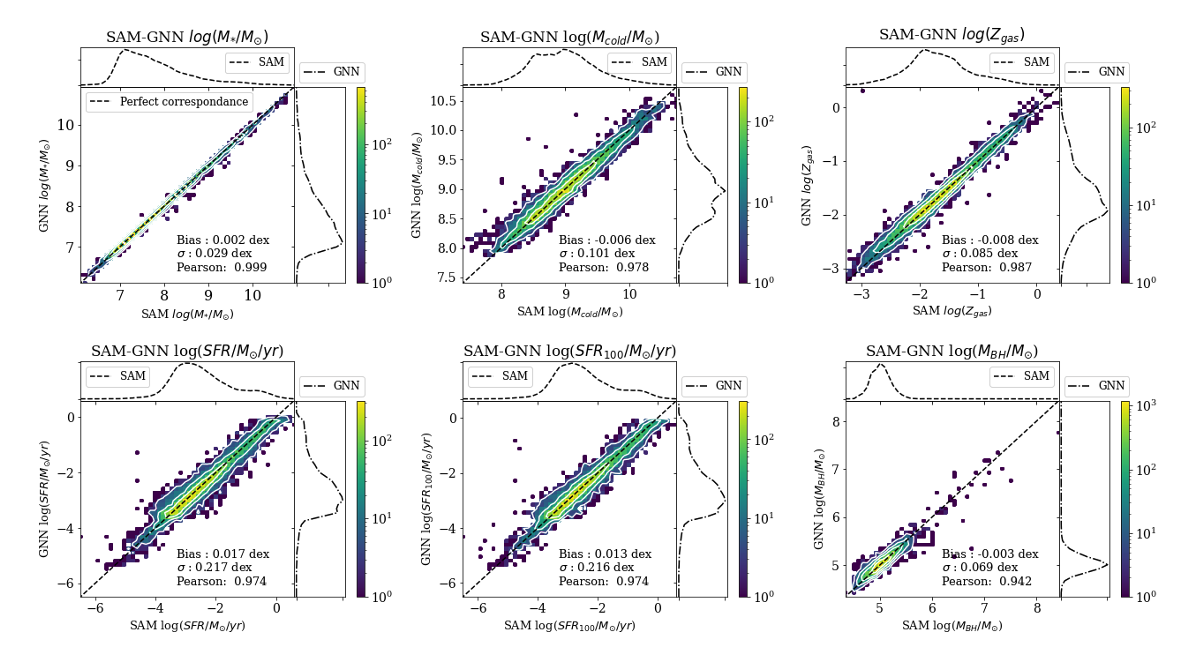

## Where is all the information coming from? High-z, low-z, just the major mergers?
### Try cutting the tree?

In [26]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [27]:
## now we do percentiles
percentile = 50
dat=[]
for d in tqdm(data, total=len(data)):
    hals=d.x.numpy()
    mask=hals[:,0]>np.percentile(hals[:,0], percentile)
    de, pr = d.edge_index
    if np.sum(mask[1:])!=0:
        desc, progs = convert(list(np.array(pr)[mask[1:]]), list(np.array(de)[mask[1:]]) )
    else:
        desc, progs=[0],[0]
    edge_index = torch.tensor([progs, desc], dtype=torch.long)
    if np.sum(mask)==0:
        mask[0]=True
    x = torch.tensor(hals[mask], dtype=torch.float)  
    y=d.y
    
    graph=Data(x=x, edge_index=edge_index, y=y)
    dat.append(graph)

  0%|          | 0/13543 [00:00<?, ?it/s]

In [28]:
test_idx = np.random.choice(np.arange(len(dat)), size = int(len(dat)*0.2))

targets = [8] ## M_star, see https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4 for other targets!

test_data, train_data = [], []
for i, d in enumerate(dat):
  if i in test_idx:
    test_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))
  else:
    train_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))

n_feat = len(train_data[0].x[0])
n_targ = len(train_data[0].y)

test_loader=DataLoader(test_data, batch_size=256, shuffle=0, num_workers=2)   
train_loader=DataLoader(train_data, batch_size=256, shuffle=1, num_workers=2)

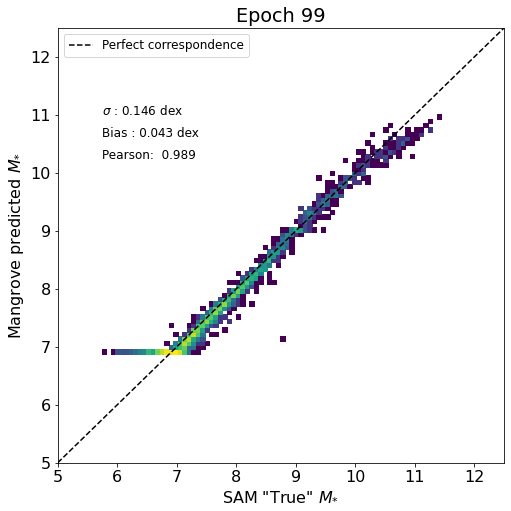

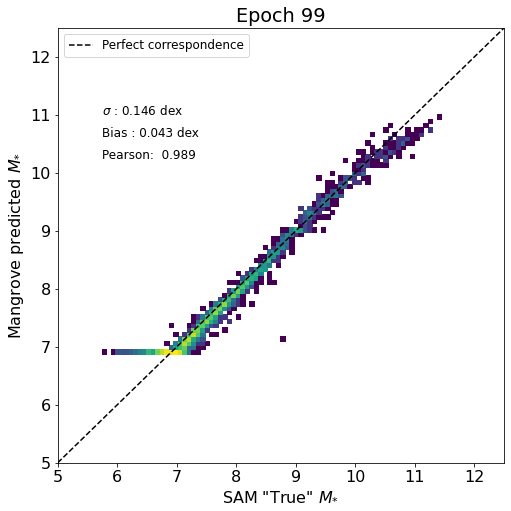

In [29]:
plot = True

if lossfunc == 'gauss':
  config['hyper_params']['variance'] = True
if lossfunc == 'L2':
  config['hyper_params']['variance'] = False
model = Mangrove(**config['hyper_params'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=n_epochs*len(train_loader), pct_start=0.15, final_div_factor=1e3)

if plot:
  fig, ax = plt.subplots(figsize = (8,8))
  bins = 100
  r = [5,12.5]
  xt = 0.1
  yt =0.8
  dy = 0.05

precisionTree = []
for epoch in tqdm(range(n_epochs)):
  trainloss, err_loss, sig_loss, l1_loss, l2_loss = train(epoch, train_loader)
  if (epoch+1)%val_epoch == 0:
    print(f'{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision, {sig_loss:.2E} coming from the magnitude of the uncertainties \n and {l1_loss+l2_loss:2E} coming from regularization')
    ys, preds, sigs, Mhalo = test(test_loader, model, lossfunc = lossfunc)
    rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0,1]
    std = np.std(ys-preds, axis=0)
    mu = np.mean(ys-preds, axis=0)
    precisionTree.append(std)
    print(f'Epoch {epoch+1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}')

    if plot:
      ax.cla()
      simple_plot(ys, preds)
      display.clear_output(wait=True)
      display.display(fig)

If we do this for many different cuts we get the following relation.

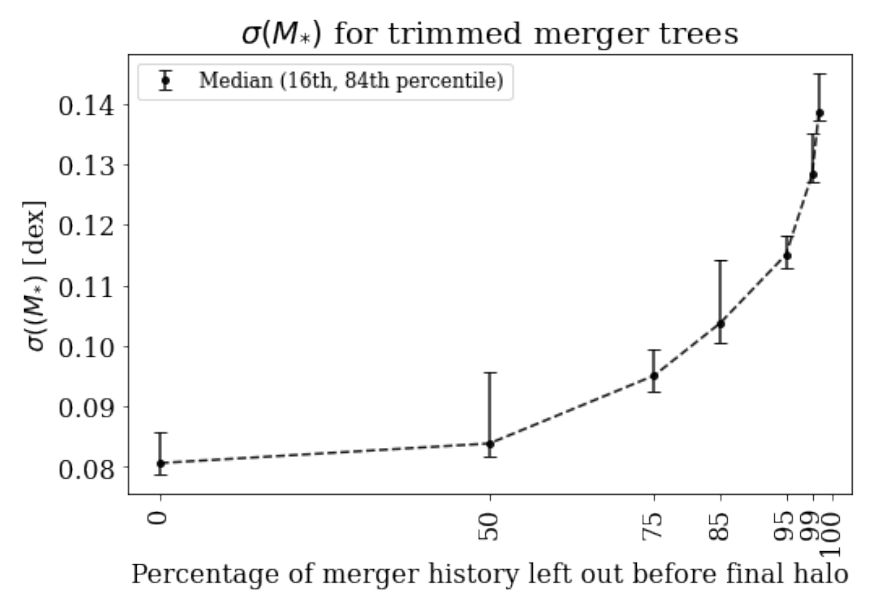

# FAQs

## Hydro Sims

Yes, this also works on IllustrisTNG, watch out for Chuang, Jespersen et al. (in prep)

## Redshift dependence

Yes it works for all redshift, and it's pretty solid at interpolating between redshifts.

## Interpretability

Because we use the GraphSAGE layer, we can try interpreting the function with PySR and get an equation that works **over the merger tree**!

This is because we can write a simplified network as:

$$ h(\Sigma (f(Halo)+e(\Sigma_{ \mathcal{N}} Halo)) $$

And then determine h, f, and e separately with PySR!

We're already getting good symbolic laws for some of the outputs, that are significantly better than other analytic methods out there!